# 24장 트랜스포머 직접 만들어 보기

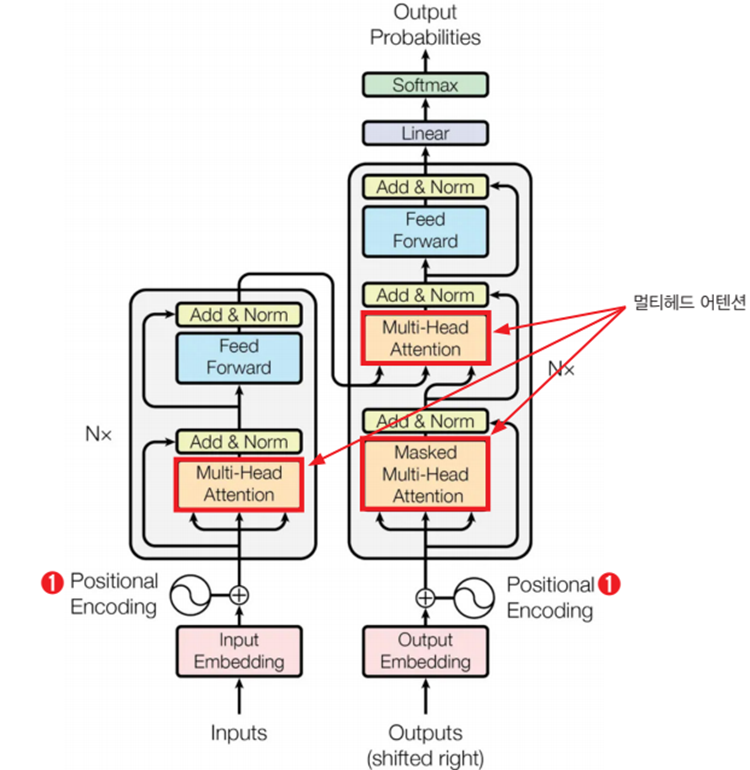

트랜스포머를 이용하면 번역, 텍스트 생성, 문서 요약, 질의 응답, 감정 분석, 음성 및 이미지, 코드 자동 완성 및 생성등을 하는  AI프로그램을 만들 수 있다.<br />
언어에서는 다음 예 처럼 순서가 중요하다는 것을 알 수 가 있다<br />
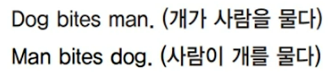<br />
어순에 따라서 완전히 다른 내용이 된다는 것을 알 수 있다.<br />
어텐션만으로는 언어의 순서를 딸 달라지는 것을 판단할 수 없어 positional Encodeing을 사용하여 언어의 순서를 기억할 수 있게 했는데 이것을 트랜스퍼머라고 한다.<br />
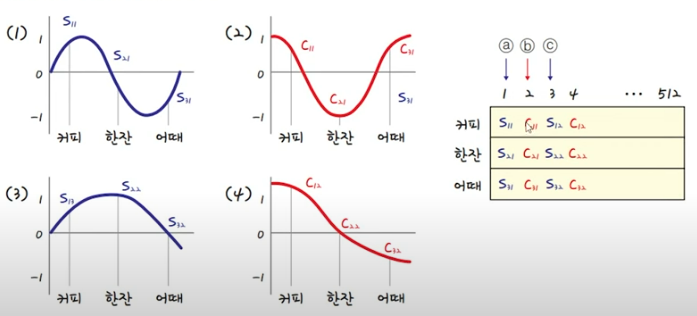<br />
위 그림 처럼 같은 문장이어도 각 단어에 위치정보를 위치정보를 sin(사인)값과 cos(코사인) 값으로 저장하여 position을 정해 어텐션으로 저장한다.<br />
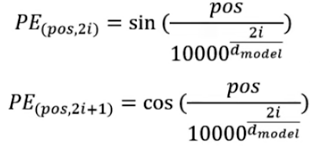<br />
사인값과 코사인값이 저장되는 공식이다.<br />
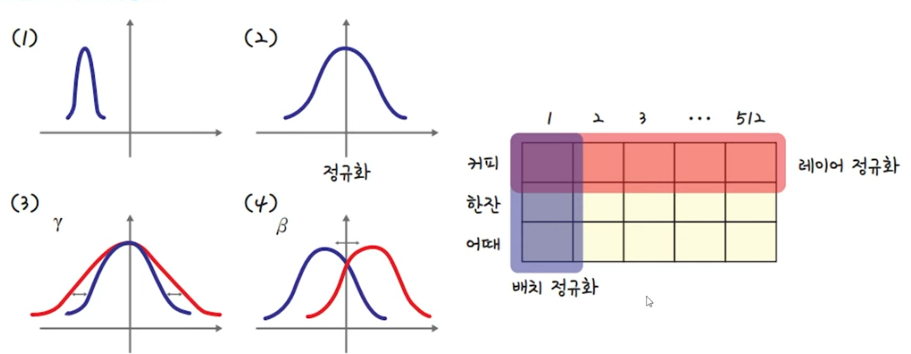<br />
정규화 과정을 거치는데 배치 정규화 과정과 감마와 베타라는 과정을 거쳐 한쪽으로 치우이는 것을 막아주는 레이어 정규화 관정을 거치게 된다.

### 잔차 연결
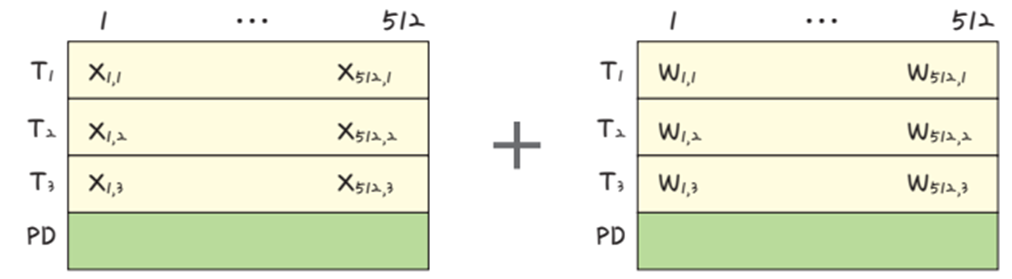<br />
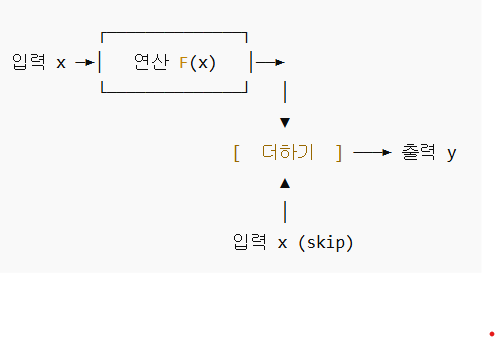<br />
기울기 소실 완화 : 깊은 신경망 학습 가능<br />
학습 속도 향상<br />
일반화 성능 개선<br />
네트워크가 항등 함수도 쉽게 표현 가능<br />

## 트랜스포머 인코더를 활용한 긍정 부정 예측


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, LayerNormalization, Dropout, Add, Input
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# CSV 파일 로드
dataframe = pd.read_csv('https://raw.githubusercontent.com/SoongMoo/data/refs/heads/main/sentiment_data.csv')
# 긍정평가와 부정 평가가 2000개가 있다.

# 데이터와 라벨 추출 : tolist()는 데이터 프레임을 리스트로 가져옴
sentences = dataframe['sentence'].tolist()  # 내용만 가져옴 
labels = dataframe['label'].tolist() # 부정과 긍정인 결과를 가져옴 

# 임베딩 벡터 크기와 최대 문장 길이 설정
embedding_dim = 128  
max_len = 10  # 글자의 갯수

# 토크나이저 초기화 및 텍스트를 시퀀스로 변환
tokenizer = tf.keras.preprocessing.text.Tokenizer() # 공백문자를 기준으로  단어를 구분한다.
tokenizer.fit_on_texts(sentences) # 단어-정수 인덱스(word-to-integer index) 맵핑.
'''
sentences 안에 있는 모든 단어를 스캔해서 단어 사전(word_index) 을 만든다.
예를 들어
sentences = ["커피 한잔 어때", "오늘 날씨 좋아"]
word_index = {"커피":1, "한잔":2, "어때":3, "오늘":4, "날씨":5, "좋아":6}
'''

sequences = tokenizer.texts_to_sequences(sentences)
'''
["커피 한잔 어때"] → [1, 2, 3]
["오늘 날씨 좋아"] → [4, 5, 6]
라면 sequences를 다음과 같이 만들어준다. 
sequences = [[1, 2, 3], [4, 5, 6]]
'''

word_index = tokenizer.word_index # 입력데이터가 된다.
'''
sentences = ["커피 한잔 어때", "오늘 날씨 좋아"]
sentences가 위와 같을 때 
{'커피': 1, '한잔': 2, '어때': 3, '오늘': 4, '날씨': 5, '좋아': 6}
문장의 단어에 index값을 갖게 된다.
'''

# 패딩을 사용하여 시퀀스 길이를 동일하게 맞춤
data = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len, padding='post')
# 문장의 길이가 다른 경우 pad_sequences를 사용해 같은 길이로 맞춰주는 과정을 한다
# padding='post'은 뒤쪽에 0으로 채움
'''
sequences = [[1, 2, 3], [4, 5], [6]]
max_len = 5
라고한다면 data 변수 값은 아래와 같게 된다.
[[1 2 3 0 0]
 [4 5 0 0 0]
 [6 0 0 0 0]]
'''

# 데이터셋을 훈련 세트와 검증 세트로 분리
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

# 포지셔널 인코딩 함수
def get_positional_encoding(max_len, d_model):
    pos_enc = np.zeros((max_len, d_model))
    for pos in range(max_len):
        for i in range(0, d_model, 2): # sin값을 넣기 위해 2의 배수씩증가 
            pos_enc[pos, i] = np.sin(pos / (10000 ** (2 * i / d_model)))
            if i + 1 < d_model: # cos값을 넣기 위해 2의 배수에 더하기 1을 
                pos_enc[pos, i + 1] = np.cos(pos / (10000 ** (2 * (i + 1) / d_model)))
    return pos_enc

# 포지셔널 인코딩 생성
positional_encoding = get_positional_encoding(max_len, embedding_dim)

# 멀티헤드 어텐션 레이어 (마스크 미사용)
class MultiHeadSelfAttentionLayer(tf.keras.layers.Layer):

    # 멀티헤드 어텐션을 만듦
    def __init__(self, num_heads, key_dim):
        super(MultiHeadSelfAttentionLayer, self).__init__()
                                                    # '헤드'의 개수        ,각 헤드에서 사용할 쿼리(Query), 키(Key), 값(Value) 벡터의 차원
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.norm = LayerNormalization()  # 레이어 정규화 

    # 정규화와 전차 연결
    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x)
        attn_output = self.norm(attn_output + x) # 배치 정규화
        return attn_output

# 모델 설정
inputs = Input(shape=(max_len,))

# 1. 임베딩 레이어
embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim)
embedded_sequences = embedding_layer(inputs)
'''
입력:  [15, 8, 102] : word_index
출력: [
   [0.12, -0.53, ..., 0.44],   # 단어 15의 128차원 벡터
   [0.31,  0.07, ..., -0.22],  # 단어 8의 128차원 벡터
   [0.99, -0.11, ..., 0.03]    # 단어 102의 128차원 벡터
]
'''

# 2. 포지셔널 인코딩 추가
embedded_sequences_with_positional_encoding = embedded_sequences + positional_encoding
# 임배당만으로는 단어의 순서를 알 수 없으므로 "이 단어가 무엇인지고 문장에서 몇 번째에 있는지" 정보를 합친 벡터를 만듦

# 3. 첫 번째 멀티헤드 어텐션 (마스크 없음)
attention_layer = MultiHeadSelfAttentionLayer(num_heads=8, key_dim=embedding_dim)
attention_output = attention_layer(embedded_sequences_with_positional_encoding) # call메서드 
                                   # 포지셔널 인코딩을 멀타헤드어텐션에 넣어준다.

# 4. 잔차 연결
attention_output_with_residual = Add()([embedded_sequences_with_positional_encoding, attention_output])

# 5. GlobalAveragePooling1D 
# 하나의 고정된 크기의 벡터로 요약하는 데 사용
pooled_output = GlobalAveragePooling1D()(attention_output_with_residual)
                # GlobalAveragePooling1D() : 시퀀스 차원(sequence_length)을 평균으로 압축
                # GlobalAveragePooling1D를 사용하는 주된 이유는 바로 문장(시퀀스)을 하나의 고정 길이 벡터로 요약하기 위해서

# 6. 피드 포워드 네트워크
dense_layer = Dense(128, activation='relu')(pooled_output)
dropout_layer = Dropout(0.5)(dense_layer)
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

model = Model(inputs=inputs, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, np.array(y_train), epochs=10, batch_size=16, validation_data=(X_val, np.array(y_val)))

# 새 문장 예측
sample_texts = ["I absolutely love this!", "I can't stand this product"]
sample_sequences = tokenizer.texts_to_sequences(sample_texts)
sample_data = tf.keras.preprocessing.sequence.pad_sequences(sample_sequences, maxlen=max_len, padding='post')
predictions = model.predict(sample_data)

for i, text in enumerate(sample_texts):
    print(f"Text: {text}")
    print(f"Prediction: {'Positive' if predictions[i] > 0.5 else 'Negative'}")


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5680 - loss: 0.8149 - val_accuracy: 0.9975 - val_loss: 0.0172
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9898 - loss: 0.0427 - val_accuracy: 0.9975 - val_loss: 0.0219
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9894 - loss: 0.0393 - val_accuracy: 0.9975 - val_loss: 0.0181
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9961 - loss: 0.0160 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9990 - loss: 0.0089 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9964 - loss: 0.0082 - val_accuracy: 0.9850 - val_loss: 0.0342
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9965 - loss: 0.0166 - val_accuracy: 0.9975 - val_loss: 0.0087
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9972 - loss: 0.0227 - val_accu

## 전체 트랜스 포머 실행하기

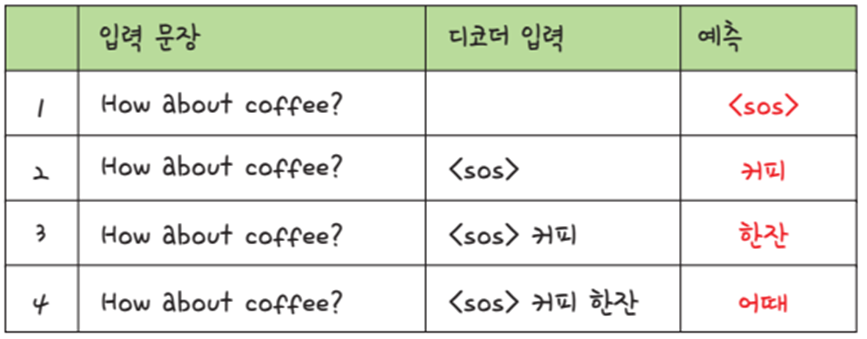<br />
"커피 한잔 어때"라는 문장을 번역을 한다고 했을때 문장을 만든 후에 학습을 한다면 전체 문장때문에 잘 못된 단어를 예측할 수 있으므로 뒤에 문장때문에 앞의 문장에 영향이 없게 하기 위해서 뒤에 문장을 가려야 한다 <br />
그러기 이해서는 뒤에 문장을 가려서 예측하여 학습을 하게끔 해야 한다,<br />
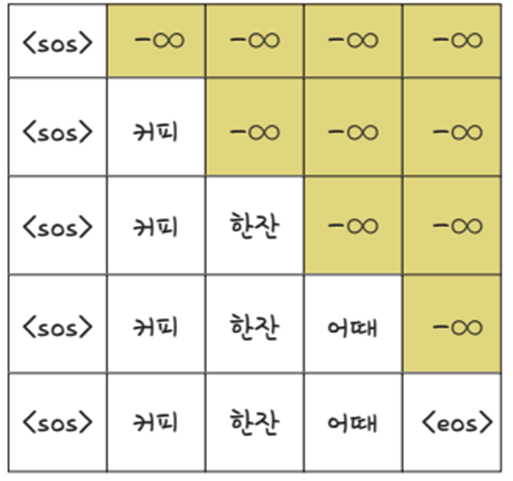<br />
학습하는 동안에는 뒤에 문장이 보이지 않게 해야 하는데 그것을 마스크라고 한다

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, LayerNormalization, Dropout, Add, Input
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 깃허브에 준비된 데이터를 가져옵니다.
!git clone https://github.com/taehojo/data.git

# CSV 파일 로드
dataframe = pd.read_csv('./data/sentiment_data.csv')

# 데이터와 라벨 추출
sentences = dataframe['sentence'].tolist()
labels = dataframe['label'].tolist()

# 임베딩 벡터 크기와 최대 문장 길이 설정
embedding_dim = 128
max_len = 10

# 토크나이저 초기화 및 텍스트를 시퀀스로 변환
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
word_index = tokenizer.word_index

# 패딩을 사용하여 시퀀스 길이를 동일하게 맞춤
data = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len, padding='post')

# 데이터셋을 훈련 세트와 검증 세트로 분리
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

# 포지셔널 인코딩 함수
def get_positional_encoding(max_len, d_model):
    pos_enc = np.zeros((max_len, d_model))
    for pos in range(max_len):
        for i in range(0, d_model, 2):
            pos_enc[pos, i] = np.sin(pos / (10000 ** (2 * i / d_model)))
            if i + 1 < d_model:
                pos_enc[pos, i + 1] = np.cos(pos / (10000 ** (2 * (i + 1) / d_model)))
    return pos_enc

# 포지셔널 인코딩 생성
positional_encoding = get_positional_encoding(max_len, embedding_dim)

# 멀티헤드 어텐션 레이어(마스크 지원)
class MultiHeadSelfAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim, masked=False): # masked부분을 주므로 멀티헤드어텐션을 만들때 마ㅡ크를 사용하게 한다,
        super(MultiHeadSelfAttentionLayer, self).__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        # query, key, value를 이용한 셀프 어텐션 수행 가능
        # num_heads × key_dim 만큼의 병렬 어텐션을 수행
        
        self.norm = LayerNormalization() # 정규화에 사용

        # 마스크 사용시 마스크 사용유무를 위해 추가
        self.masked = masked  # call에서 마스크를 사용할 것인지 아닌지 정

    def call(self, x):
        if self.masked:
            batch_size = tf.shape(x)[0] # 입력 배치 크기
            seq_len = tf.shape(x)[1] # 시퀀스 길이 추출
            mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0) # 위 그림의 마스크 행렬을 만들어 주기 위해 먼저 1로 채운다.
            '''
                band_part(..., -1, 0) 의미 : 하삼각함수
                -1 : 무제한 하삼각 포함 , 대각선과 아래쪽 모두 포함
                 0 : 상삼각 없음 , 대각선 위쪽은 모두 0
            아래와 같은 모양을 만든다.
                [[1, 0, 0, 0],
                 [1, 1, 0, 0],
                 [1, 1, 1, 0],
                 [1, 1, 1, 1]]
            위치 i에서 i 이후 단어는 보지 못하게 함
            Decoder에서 미래 토큰을 참조하지 못하게 하는 용도
            '''
            mask = tf.reshape(mask, (1, 1, seq_len, seq_len))
            '''
                배치 차원과 헤드 차원을 맞춰준다.
                1번째 1 : 배치 차원 placeholder
                2번째 1 : 헤드 차원 placeholder

                mask 차원을 MultiHeadAttention이 이해할 수 있는 형식으로 바꾸는 과정
            '''
            mask = tf.tile(mask, [batch_size, 1, 1, 1]) # 배치 사이크에 맞게 마스크를 복제해서 사용
            mask = (1-mask) * -1e9 # mask가 0인 위치는 -1e9로 만들어 softmax에서 거의 0이 되도록 처리
            '''
                mask = [[1, 0, 0, 0],
                        [1, 1, 0, 0],
                        [1, 1, 1, 0],
                        [1, 1, 1, 1]] 이었을 때
                (1-mask)을 했을 때
                1 - mask = [[0, 1, 1, 1],
                            [0, 0, 1, 1],
                            [0, 0, 0, 1],
                            [0, 0, 0, 0]] 이 되어 의미로는 1은 참조 금지, 0은 참조 가능이며
                mask * -1e9을 하면
                    mask = [[0, -1e9, -1e9, -1e9],
                            [0,    0, -1e9, -1e9],
                            [0,    0,    0, -1e9],
                            [0,    0,    0,    0]]
            '''
            attn_output = self.mha(query=x, value=x, key=x, attention_mask=mask)
        else:
            attn_output = self.mha(query=x, value=x, key=x)
        attn_output = self.norm(attn_output + x)
        return attn_output

# 모델 설정
inputs = Input(shape=(max_len,))

# 1. 임베딩 레이어
embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim)
embedded_sequences = embedding_layer(inputs)

# 2. 포지셔널 인코딩 추가
embedded_sequences_with_positional_encoding = embedded_sequences + positional_encoding


# 3. 첫 번째 멀티헤드 어텐션 (마스크 없음)  : encode 부분
attention_layer = MultiHeadSelfAttentionLayer(num_heads=8, key_dim=embedding_dim)
attention_output = attention_layer(embedded_sequences_with_positional_encoding)

# 4. 잔차 연결
attention_output_with_residual = Add()([embedded_sequences_with_positional_encoding, attention_output])

######## 마스크 있을 때 추가 시작

# 5. 마스크드 멀티헤드 어텐션 (마스크 있음) decode부분
masked_attention_layer = MultiHeadSelfAttentionLayer(num_heads=8, key_dim=embedding_dim, masked=True)
masked_attention_output = masked_attention_layer(attention_output_with_residual)

# 6. 잔차 연결
masked_attention_output_with_residual = Add()([attention_output_with_residual, masked_attention_output])

#######   끝

# 7. GlobalAveragePooling1D
pooled_output = GlobalAveragePooling1D()(masked_attention_output_with_residual)

# 8. 피드 포워드 네트워크
dense_layer = Dense(128, activation='relu')(pooled_output)
dropout_layer = Dropout(0.5)(dense_layer)
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

model = Model(inputs=inputs, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, np.array(y_train), epochs=10, batch_size=16, validation_data=(X_val, np.array(y_val)))

# 새 문장 예측
sample_texts = ["I absolutely love this!", "I can't stand this product"]
sample_sequences = tokenizer.texts_to_sequences(sample_texts)
sample_data = tf.keras.preprocessing.sequence.pad_sequences(sample_sequences, maxlen=max_len, padding='post')
predictions = model.predict(sample_data)

for i, text in enumerate(sample_texts):
    print(f"Text: {text}")
    print(f"Prediction: {'Positive' if predictions[i] > 0.5 else 'Negative'}")

# 여기서 seq_len=4, batch_size=2로 예를 들어 마스크 행렬을 생성하고 출력해보는 예제
seq_len_example = 4
batch_size_example = 2
mask_example = tf.linalg.band_part(tf.ones((seq_len_example, seq_len_example)), -1, 0)
mask_example = tf.reshape(mask_example, (1, 1, seq_len_example, seq_len_example))
mask_example = tf.tile(mask_example, [batch_size_example, 1, 1, 1])

print("\n예시 마스크 행렬 :")
print(mask_example.numpy()[0, 0, :, :])

mask_example = (1-mask_example) * -1e9
print("\n-∞로 치환한 마스크 행렬:")
print(mask_example.numpy()[0, 0, :, :])


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.5022 - loss: 1.1726 - val_accuracy: 0.9900 - val_loss: 0.0442
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9829 - loss: 0.0847 - val_accuracy: 0.9975 - val_loss: 0.0199
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9907 - loss: 0.0472 - val_accuracy: 0.9975 - val_loss: 0.0131
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9966 - loss: 0.0219 - val_accuracy: 0.9975 - val_loss: 0.0196
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9955 - loss: 0.0380 - val_accuracy: 0.9975 - val_loss: 0.0176
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9965 - loss: 0.0227 - val_accuracy: 0.9975 - val_loss: 0.0179
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9993 - loss: 0.0106 - val_accuracy: 1.0000 - val_loss: 0.0057
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9994 - loss: 0.0115 - val_accu

In [ ]:
트랜스퍼머를 이용한 한영번역기

In [ ]:
# ==============================
# 1️ 라이브러리
# ==============================
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, LayerNormalization, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pickle

# ==============================
# 2️ 커스텀 Self-Attention 레이어
# ==============================
class MultiHeadSelfAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim, masked=False, **kwargs):
        super().__init__(**kwargs)
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.norm = LayerNormalization()
        self.masked = masked

    def call(self, x, enc_output=None):
        if self.masked:
            # 디코더에서 future mask 생성
            batch_size = tf.shape(x)[0]
            seq_len = tf.shape(x)[1]
            mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
            mask = tf.reshape(mask, (1, 1, seq_len, seq_len))
            mask = tf.tile(mask, [batch_size, 1, 1, 1])
            mask = (1 - mask) * -1e9
            attn_output = self.mha(query=x, value=x, key=x, attention_mask=mask)
        elif enc_output is not None:
            # Cross-Attention
            attn_output = self.mha(query=x, value=enc_output, key=enc_output)
        else:
            attn_output = self.mha(query=x, value=x, key=x)
        return self.norm(attn_output + x)

# ==============================
# 3️ 학습용 데이터
# ==============================
korean_sentences = ["안녕하세요", "오늘 날씨가 좋네요", "저는 학생입니다"]
english_sentences = ["<start> Hello <end>", "<start> The weather is nice today <end>", "<start> I am a student <end>"]

# ==============================
# 4️ 토크나이저
# ==============================
tokenizer_ko = Tokenizer(filters='', lower=False)
tokenizer_ko.fit_on_texts(korean_sentences)
tokenizer_en = Tokenizer(filters='', lower=False)
tokenizer_en.fit_on_texts(english_sentences)

# 저장
with open("tokenizer_ko.pkl", "wb") as f: pickle.dump(tokenizer_ko, f)
with open("tokenizer_en.pkl", "wb") as f: pickle.dump(tokenizer_en, f)

# ==============================
# 5️ 시퀀스 변환 & 패딩
# ==============================
X_seq = tokenizer_ko.texts_to_sequences(korean_sentences)
Y_seq = tokenizer_en.texts_to_sequences(english_sentences)

max_len_X = max(len(seq) for seq in X_seq)
max_len_Y = max(len(seq) for seq in Y_seq)

X_pad = pad_sequences(X_seq, maxlen=max_len_X, padding='post')
Y_pad = pad_sequences(Y_seq, maxlen=max_len_Y, padding='post')

# ==============================
# 6️ 학습 데이터 분리
# ==============================
# 디코더 입력 (<start> ~ 마지막-1)
decoder_input_data = Y_pad[:, :-1]   
# 디코더 출력 (1 ~ <end>)
decoder_target_data = Y_pad[:, 1:]   
decoder_target_data = np.expand_dims(decoder_target_data, -1)

# ==============================
# 7️ 모델 구성 (인코더-디코더 + Cross-Attention)
# ==============================
embedding_dim = 64

# 입력
encoder_inputs = Input(shape=(max_len_X,))
decoder_inputs = Input(shape=(max_len_Y-1,)) 

# 임베딩
encoder_embedded = Embedding(input_dim=len(tokenizer_ko.word_index)+1, output_dim=embedding_dim)(encoder_inputs)
decoder_embedded = Embedding(input_dim=len(tokenizer_en.word_index)+1, output_dim=embedding_dim)(decoder_inputs)

# 인코더
encoder_output = MultiHeadSelfAttentionLayer(num_heads=4, key_dim=embedding_dim)(encoder_embedded)

# 디코더 (Self-Attention + Cross-Attention)
decoder_self = MultiHeadSelfAttentionLayer(num_heads=4, key_dim=embedding_dim, masked=True)(decoder_embedded)
decoder_cross = MultiHeadSelfAttentionLayer(num_heads=4, key_dim=embedding_dim)(decoder_self, enc_output=encoder_output)

# 피드포워드 + 출력
dense1 = Dense(128, activation='relu')(decoder_cross)
drop = Dropout(0.3)(dense1)
outputs = Dense(len(tokenizer_en.word_index)+1, activation='softmax')(drop)

model = Model([encoder_inputs, decoder_inputs], outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ==============================
# 8️ 모델 학습
# ==============================
model.fit([X_pad, decoder_input_data], decoder_target_data, epochs=50, batch_size=2)

# ==============================
# 9️ 모델 저장
# ==============================
model.save("korean_to_english_model.h5")
print(" 모델 학습 및 저장 완료!")


In [ ]:
# ==============================
# 1️ 라이브러리
# ==============================
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LayerNormalization, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pickle

# ==============================
# 2️ 커스텀 Self-Attention 레이어
# ==============================
class MultiHeadSelfAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim, masked=False, **kwargs):
        super().__init__(**kwargs)
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.norm = LayerNormalization()
        self.masked = masked

    def call(self, x, enc_output=None):
        if self.masked:
            # 디코더에서 future mask 생성
            batch_size = tf.shape(x)[0]
            seq_len = tf.shape(x)[1]
            mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
            mask = tf.reshape(mask, (1, 1, seq_len, seq_len))
            mask = tf.tile(mask, [batch_size, 1, 1, 1])
            mask = (1 - mask) * -1e9
            attn_output = self.mha(query=x, value=x, key=x, attention_mask=mask)
        elif enc_output is not None:
            # Cross-Attention
            attn_output = self.mha(query=x, value=enc_output, key=enc_output)
        else:
            attn_output = self.mha(query=x, value=x, key=x)
        return self.norm(attn_output + x)
        
# ==============================
# 3️ 토크나이저 불러오기
# ==============================
with open("tokenizer_ko.pkl", "rb") as f:
    tokenizer_ko = pickle.load(f)
with open("tokenizer_en.pkl", "rb") as f:
    tokenizer_en = pickle.load(f)

# ==============================
# 4️ 새 학습 데이터 입력 (while + input)
# ==============================
new_korean_sentences = []
new_english_sentences = []

print("새 학습 문장을 추가합니다. 종료하려면 'exit' 입력")
while True:
    ko = input("한글 문장 입력: ")
    if ko.lower() == "exit":
        break
    en = input("영어 번역 입력: ")
    if en.lower() == "exit":
        break
    en = f"<start> {en} <end>"
    new_korean_sentences.append(ko)
    new_english_sentences.append(en)

if len(new_korean_sentences) == 0:
    print("새 문장이 없어서 학습을 종료합니다.")
    exit()

# ==============================
# 5️ 시퀀스 변환
# ==============================
X_seq_new = tokenizer_ko.texts_to_sequences(new_korean_sentences)
Y_seq_new = tokenizer_en.texts_to_sequences(new_english_sentences)

# ==============================
# 6️ 기존 모델 불러오기
# ==============================
model = load_model(
    "korean_to_english_model.h5",
    custom_objects={"MultiHeadSelfAttentionLayer": MultiHeadSelfAttentionLayer},
    compile=False
)

# 기존 모델 입력 길이
max_len_encoder_input = model.input_shape[0][1]
max_len_decoder_input = model.input_shape[1][1]

# ==============================
# 7️ 패딩 및 decoder input/target 준비
# ==============================
X_pad_new = pad_sequences(X_seq_new, maxlen=max_len_encoder_input, padding='post')
decoder_input_new = pad_sequences(Y_seq_new, maxlen=max_len_decoder_input+1, padding='post')[:, :-1]
decoder_target_new = pad_sequences(Y_seq_new, maxlen=max_len_decoder_input+1, padding='post')[:, 1:]
decoder_target_new = np.expand_dims(decoder_target_new, -1)

# ==============================
# 8️ 기존 레이어 freeze (Embedding, Self-Attention)
# ==============================
for layer in model.layers:
    if 'embedding' in layer.name or 'multi_head_self_attention' in layer.name:
        layer.trainable = False
# 마지막 Dense 레이어만 학습
if hasattr(model.layers[-1], 'trainable'):
    model.layers[-1].trainable = True

# ==============================
# 9️ Fine-tuning
# ==============================
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(
    [X_pad_new, decoder_input_new],
    decoder_target_new,
    epochs=20,
    batch_size=2,
    shuffle=True
)

model.save("korean_to_english_model.h5")
print(" 새 문장 추가 학습 완료!")


In [ ]:
# ==============================
# 1 라이브러리
# ==============================
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pickle

# ==============================
# 2️ 커스텀 레이어
# ==============================
class MultiHeadSelfAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim, masked=False, **kwargs):
        super().__init__(**kwargs)
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.norm = LayerNormalization()
        self.masked = masked

    def call(self, x, enc_output=None):
        if self.masked:
            # 디코더에서 future mask 생성
            batch_size = tf.shape(x)[0]
            seq_len = tf.shape(x)[1]
            mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
            mask = tf.reshape(mask, (1, 1, seq_len, seq_len))
            mask = tf.tile(mask, [batch_size, 1, 1, 1])
            mask = (1 - mask) * -1e9
            attn_output = self.mha(query=x, value=x, key=x, attention_mask=mask)
        elif enc_output is not None:
            # Cross-Attention
            attn_output = self.mha(query=x, value=enc_output, key=enc_output)
        else:
            attn_output = self.mha(query=x, value=x, key=x)
        return self.norm(attn_output + x)

# ==============================
# 3️ 모델 불러오기
# ==============================
model = load_model(
    "korean_to_english_model.h5",
    custom_objects={'MultiHeadSelfAttentionLayer': MultiHeadSelfAttentionLayer}
)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')  # 재컴파일
print("모델 불러오기 완료!")

# ==============================
# 4️ 토크나이저 불러오기
# ==============================
with open("tokenizer_ko.pkl", "rb") as f:
    tokenizer_ko = pickle.load(f)
with open("tokenizer_en.pkl", "rb") as f:
    tokenizer_en = pickle.load(f)
print("토크나이저 불러오기 완료!")

# ==============================
# 5️ 모델 학습 시 사용한 최대 길이
# ==============================
encoder_max_len = 3
decoder_max_len = 6

# ==============================
# 6️ 번역 함수
# ==============================
def translate(korean_sentence):
    X_seq = tokenizer_ko.texts_to_sequences([korean_sentence])
    X_pad = pad_sequences(X_seq, maxlen=encoder_max_len, padding='post').astype(np.int32)

    decoder_input = [tokenizer_en.word_index['<start>']]
    output_sentence = []

    for i in range(decoder_max_len - 1):
        decoder_input_pad = pad_sequences([decoder_input], maxlen=decoder_max_len, padding='post').astype(np.int32)
        preds = model.predict([X_pad, decoder_input_pad], verbose=0)
        pred_id = np.argmax(preds[0, i, :])

        if pred_id == tokenizer_en.word_index.get('<end>', -1):
            break
        output_sentence.append(pred_id)
        decoder_input.append(pred_id)

    idx_to_word = {v: k for k, v in tokenizer_en.word_index.items()}
    translated = ' '.join([idx_to_word.get(id, '') for id in output_sentence])
    return translated.strip()

# ==============================
# 7️ 테스트
# ==============================
while True:
    korean = input("한글 문장 입력 (종료: exit) ---\n한글: ")
    if korean.lower() == "exit":
        break
    english = translate(korean)
    print("영어 번역:", english)
